# Z lokalit k obcím jinak

In [1]:
import camelot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get pdf from the web and use Camelot to retrieve tables
tables = camelot.read_pdf('https://www.eru.cz/documents/10540/462926/Vysledne_ceny_tepla_2018.pdf', pages='1-end')
tables

<TableList n=44>

In [2]:
# Prepare header and labels
header = ['lokalita', 'kraj', 'pod_uhli', 'pod_plyn', 'pod_bio', 'pod_olej',\
          'pod_ost', 'vykon', 'pocet_odberat', 'pocet_mist', 'nad_10_czk', 'nad_10_gj',\
          'pod_10_czk','pod_10_gj','cptv_czk', 'cptv_gj',\
          'prim_rozv_czk', 'prim_rozv_gj','cvs_czk', 'cvs_gj',\
          'cvs_voda_czk', 'cvs_voda_gj','blok_kot_czk', 'blok_kot_gj',\
          'sek_rozv_czk', 'sek_rozv_gj',\
          'dps_czk', 'dps_gj', 'dom_kot_czk', 'dom_kot_gj']
podily = ['pod_uhli', 'pod_plyn', 'pod_bio', 'pod_olej', 'pod_ost']
labels = ['uhlí', 'zemní plyn', 'biomasa', 'topný olej', 'jiné']

# Merge all tables into one DataFrame
ceny = []
for i in range(tables.n):
    ceny.extend(tables[i].data[2:])
ceny = pd.DataFrame(ceny, columns=header)

# Clean strings (decimal, thousand), repair null and convert to numeric types
ceny.loc[:, 'pod_uhli':] = ceny.loc[:, 'pod_uhli':].apply(lambda x: x.str.replace(',', '.'))
ceny.loc[:, 'pod_uhli':] = ceny.loc[:, 'pod_uhli':].apply(lambda x: x.str.replace(' ', ''))
ceny.loc[:, 'pod_uhli':] = ceny.loc[:, 'pod_uhli':].apply(pd.to_numeric)
ceny.loc[:, 'pocet_odberat':'pocet_mist'] = ceny.loc[:, 'pocet_odberat':'pocet_mist'].astype('int64')
ceny = ceny.fillna(0)
ceny['lokalita'] = ceny['lokalita'].apply(lambda x: x.replace('\0', 'ti')) #There is a null value 


In [3]:
#ceny.loc[:, 'pod_uhli':'pod_ost'] =  ceny.loc[:, 'pod_uhli':'pod_ost']/100

In [4]:
ceny.head()

,lokalita,kraj,pod_uhli,pod_plyn,pod_bio,pod_olej,pod_ost,vykon,pocet_odberat,pocet_mist,...,cvs_voda_czk,cvs_voda_gj,blok_kot_czk,blok_kot_gj,sek_rozv_czk,sek_rozv_gj,dps_czk,dps_gj,dom_kot_czk,dom_kot_gj
0,Abertamy,K,0.0,100.0,0.0,0.0,0.0,0.810,2,1,...,0.0,0.0,570.27,1139.0,0.0,0.0,0.00,0.0,0.00,0.0
1,Adamov,B,0.0,100.0,0.0,0.0,0.0,2.203,1,1,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0
2,Adamov - Opletalova 38 a 22,B,0.0,100.0,0.0,0.0,0.0,0.460,2,2,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,662.43,1382.0
3,Adamov - P. Jilemnického 18 (K 72),B,0.0,100.0,0.0,0.0,0.0,0.090,1,1,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,324.49,514.0
4,Adamov - teplovodní zdroj,B,0.0,100.0,0.0,0.0,0.0,9.000,37,28,...,0.0,0.0,0.00,0.0,0.0,0.0,540.92,26492.0,0.00,0.0


In [5]:
# Agregate energy and price from various supply options
gj = ceny.filter(regex='_gj+', axis=1).columns
czk = ceny.filter(regex='_czk+', axis=1).columns
ceny['dod_cena'] = np.average(ceny[czk], weights=ceny[gj], axis=1)
ceny['dod_mnozstvi'] = np.sum(ceny[gj], axis=1)

ceny.dod_mnozstvi.sum() == ceny.filter(regex='_gj+', axis=1).sum().sum()

True

In [6]:
np.average(ceny.filter(regex='_czk+', axis=1), weights=ceny.filter(regex='_gj+', axis=1))

421.06020878600896

In [7]:
np.average(ceny['dod_cena'], weights=ceny['dod_mnozstvi'])

421.0602087860089

In [8]:
df = pd.DataFrame()

In [9]:
# Obce z lokalit
df['obec'] = ceny.lokalita.str.split('-', 1).str.get(0).str.strip()
df['obec'] = df['obec'].replace('[0-9]*/*,*', '', regex=True).str.strip()
df['obec'] = df['obec'].str.rstrip('I*V*X*').str.strip()
df.obec.value_counts().size

773

In [10]:
df['kraj'] = ceny['kraj']
df['pocet_odberat'] = ceny['pocet_odberat']
df['pocet_mist'] = ceny['pocet_mist']
df['teplo_mnozstvi'] = ceny['dod_mnozstvi']
df['teplo_cena'] = ceny['dod_cena']
df['uhli'] = ceny['dod_mnozstvi'] * ceny['pod_uhli']/100
df['plyn'] = ceny['dod_mnozstvi'] * ceny['pod_plyn']/100
df['biomasa'] = ceny['dod_mnozstvi'] * ceny['pod_bio']/100
df['olej'] = ceny['dod_mnozstvi'] * ceny['pod_olej']/100
df['ostatni'] = ceny['dod_mnozstvi'] * ceny['pod_ost']/100
df['vykon'] = ceny['vykon']

In [11]:
df = df.join(ceny.loc[:, 'pod_uhli':'pod_ost'])

In [12]:
df[:10]

,obec,kraj,pocet_odberat,pocet_mist,teplo_mnozstvi,teplo_cena,uhli,plyn,biomasa,olej,ostatni,vykon,pod_uhli,pod_plyn,pod_bio,pod_olej,pod_ost
0,Abertamy,K,2,1,1764.0,570.270000,0.0,1764.0000,0.000,0.0000,0.0,0.810,0.0,100.00,0.0,0.00,0.0
1,Adamov,B,1,1,22964.0,224.940000,0.0,22964.0000,0.000,0.0000,0.0,2.203,0.0,100.00,0.0,0.00,0.0
2,Adamov,B,2,2,1382.0,662.430000,0.0,1382.0000,0.000,0.0000,0.0,0.460,0.0,100.00,0.0,0.00,0.0
3,Adamov,B,1,1,514.0,324.490000,0.0,514.0000,0.000,0.0000,0.0,0.090,0.0,100.00,0.0,0.00,0.0
4,Adamov,B,37,28,26492.0,540.920000,0.0,26492.0000,0.000,0.0000,0.0,9.000,0.0,100.00,0.0,0.00,0.0
5,Andělská Hora,T,1,1,917.0,558.900000,0.0,917.0000,0.000,0.0000,0.0,0.192,0.0,100.00,0.0,0.00,0.0
6,Arnoltice,M,3,2,1062.0,402.550000,1062.0,0.0000,0.000,0.0000,0.0,0.180,100.0,0.00,0.0,0.00,0.0
7,Aš,K,58,81,47004.0,566.416686,0.0,46674.9720,329.028,0.0000,0.0,15.650,0.0,99.30,0.7,0.00,0.0
8,Aš,K,3,3,1496.0,536.200000,0.0,1137.1096,0.000,358.8904,0.0,0.419,0.0,76.01,0.0,23.99,0.0
9,Babice,Z,1,1,5991.0,299.680000,0.0,5991.0000,0.000,0.0000,0.0,1.290,0.0,100.00,0.0,0.00,0.0


In [13]:
grouped = df.groupby('obec')
obce = pd.DataFrame()

In [14]:
obce['obec'] = grouped['obec'].first()
obce['kraj'] = grouped['kraj'].first()
obce['odberatelu'] = grouped['pocet_odberat'].sum()
obce['mist'] = grouped['pocet_mist'].sum()
obce['lokalit'] = grouped['pocet_odberat'].count()
obce['vykon'] = grouped['vykon'].sum()

In [15]:
obce['teplo_mnozstvi'] = grouped['teplo_mnozstvi'].sum()
obce['teplo_cena'] = grouped.apply(lambda x: np.average(x['teplo_cena'], weights=x['teplo_mnozstvi']))

In [16]:
for col in ['uhli', 'plyn', 'biomasa', 'olej', 'ostatni']:
    obce[col] = grouped[col].sum()
    
obce['pod_uhli'] = obce['uhli']/obce['teplo_mnozstvi']
obce['pod_plyn'] = obce['plyn']/obce['teplo_mnozstvi']
obce['pod_bio'] = obce['biomasa']/obce['teplo_mnozstvi']
obce['pod_olej'] = obce['olej']/obce['teplo_mnozstvi']
obce['pod_ost'] = obce['ostatni']/obce['teplo_mnozstvi']

obce = obce.reset_index(drop=True)
obce[:10]

,obec,kraj,odberatelu,mist,lokalit,vykon,teplo_mnozstvi,teplo_cena,uhli,plyn,biomasa,olej,ostatni,pod_uhli,pod_plyn,pod_bio,pod_olej,pod_ost
0,Abertamy,K,2,1,1,0.810,1764.0,570.270000,0.0,1764.0000,0.0000,0.0000,0.0000,0.0,1.000000,0.000000,0.0000,0.000000
1,Adamov,B,41,32,4,11.753,51352.0,400.721314,0.0,51352.0000,0.0000,0.0000,0.0000,0.0,1.000000,0.000000,0.0000,0.000000
2,Andělská Hora,T,1,1,1,0.192,917.0,558.900000,0.0,917.0000,0.0000,0.0000,0.0000,0.0,1.000000,0.000000,0.0000,0.000000
3,Arnoltice,M,3,2,1,0.180,1062.0,402.550000,1062.0,0.0000,0.0000,0.0000,0.0000,1.0,0.000000,0.000000,0.0000,0.000000
4,Aš,K,61,84,2,16.069,48500.0,565.484642,0.0,47812.0816,329.0280,358.8904,0.0000,0.0,0.985816,0.006784,0.0074,0.000000
5,Babice,Z,2,2,2,1.360,6224.0,305.631533,0.0,6224.0000,0.0000,0.0000,0.0000,0.0,1.000000,0.000000,0.0000,0.000000
6,Batelov,J,2,2,2,0.252,714.0,505.413754,0.0,714.0000,0.0000,0.0000,0.0000,0.0,1.000000,0.000000,0.0000,0.000000
7,Bechyně,C,38,58,1,7.300,30596.0,555.840000,0.0,125.4436,30470.5564,0.0000,0.0000,0.0,0.004100,0.995900,0.0000,0.000000
8,Benešov,S,58,160,5,68.933,109257.0,574.074184,0.0,106371.8771,0.0000,0.0000,2885.1229,0.0,0.973593,0.000000,0.0000,0.026407
9,Benešov nad Ploučnicí,U,14,18,2,3.657,15424.0,607.226852,0.0,15424.0000,0.0000,0.0000,0.0000,0.0,1.000000,0.000000,0.0000,0.000000


In [17]:
bio_100 = obce['pod_bio'] == 1.0

In [18]:
np.average(obce[bio_100]['teplo_cena'], weights = obce[bio_100]['biomasa'])

255.49678888621196

In [19]:
obce[bio_100]['teplo_cena'].describe()

count     98.000000
mean     312.547738
std      186.807402
min        0.510000
25%      173.075007
50%      274.000000
75%      430.937500
max      738.090000
Name: teplo_cena, dtype: float64

In [20]:
uhli_100 = obce['pod_uhli'] == 1.0
obce[uhli_100]['teplo_cena'].describe()

count     38.000000
mean     548.071533
std      146.494834
min      183.920000
25%      459.910935
50%      530.007631
75%      655.298328
max      968.010000
Name: teplo_cena, dtype: float64

In [21]:
np.average(obce[uhli_100]['teplo_cena'], weights = obce[uhli_100]['uhli'])

520.3758124161388

In [22]:
plyn_100 = obce['pod_plyn'] == 1.0
obce[plyn_100]['teplo_cena'].describe()

count     384.000000
mean      526.180814
std       118.478735
min       162.633782
25%       443.540000
50%       529.188555
75%       589.305000
max      1078.300000
Name: teplo_cena, dtype: float64

In [23]:
np.average(obce[plyn_100]['teplo_cena'], weights = obce[plyn_100]['plyn'])

513.009299398367

In [24]:
olej_100 = obce['pod_olej'] == 1.0
obce[olej_100]['teplo_cena'].describe()

count     16.000000
mean     764.754235
std       80.834975
min      557.960000
25%      723.378319
50%      768.035000
75%      808.847500
max      933.000000
Name: teplo_cena, dtype: float64

In [25]:
np.average(obce[olej_100]['teplo_cena'], weights = obce[olej_100]['olej'])

761.5240557031788

In [26]:
ost_100 = obce['pod_ost'] == 1.0
obce[ost_100]['teplo_cena'].describe()

count       3.000000
mean      850.717699
std       152.965347
min       760.500000
25%       762.410000
50%       764.320000
75%       895.826549
max      1027.333098
Name: teplo_cena, dtype: float64

In [27]:
np.average(obce[ost_100]['teplo_cena'], weights = obce[ost_100]['ostatni'])

879.0745620979712

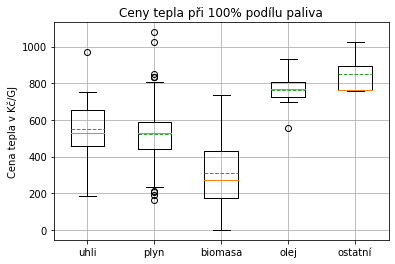

In [28]:
subset = [obce[uhli_100]['teplo_cena'], obce[plyn_100]['teplo_cena'], obce[bio_100]['teplo_cena'], obce[olej_100]['teplo_cena'], obce[ost_100]['teplo_cena']]
plt.boxplot(subset, labels=['uhli', 'plyn', 'biomasa', 'olej', 'ostatní'], showmeans=True, meanline=True)
plt.title('Ceny tepla při 100% podílu paliva')
plt.ylabel('Cena tepla v Kč/GJ')
plt.grid()
plt.show()